# Supermasks in Superposition: Training and Task Inference

<img src="images/teaser_supsup.png">

In [30]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F

import torchvision
import numpy as np
import math

from tqdm.notebook import tqdm

print("Packages loaded")
# note at edits

Packages loaded


In [316]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Training

We train our model using the procedure from "What's Hidden in a Randomly Weighted Neural Network" (Ramanujan et al. 2019). Below is a modification of the layers (using signed constant initialization) from this paper for our continual learning setup. As a deviation from this setup, we assume that an edge (u, v) is included in the subnetwork if its score is greater than 0, rather than use it's absolute magnitude to construct a threshold. 

In [62]:
# Subnetwork forward from hidden networks
class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores):
        return (scores >= 0).float()

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g
    
class GetSubnetSparse(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

def mask_init(module):
    scores = torch.Tensor(module.weight.size())
    nn.init.kaiming_uniform_(scores, a=math.sqrt(5))
    return scores


def signed_constant(module):
    fan = nn.init._calculate_correct_fan(module.weight, 'fan_in')
    gain = nn.init.calculate_gain('relu')
    std = gain / math.sqrt(fan)
    module.weight.data = module.weight.data.sign() * std


class MultitaskMaskLinear(nn.Linear):
    def __init__(self, *args, num_tasks=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_tasks = num_tasks
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        
        # Keep weights untrained
        self.weight.requires_grad = False
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j])
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            # Superimposed forward pass
            alpha_weights = self.alphas[: self.num_tasks_learned]
            idxs = (alpha_weights > 0).squeeze().view(self.num_tasks_learned)
            if len(idxs.shape) == 0:
                idxs = idxs.view(1)
            subnet = (
                alpha_weights[idxs]
                * self.stacked[: self.num_tasks_learned][idxs]
            ).sum(dim=0)
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnet.apply(self.scores[self.task])
        w = self.weight * subnet
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"MultitaskMaskLinear({self.size()})"
    
class MultitaskMaskLinearSparse(nn.Linear):
    def __init__(self, *args, num_tasks=1, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_tasks = num_tasks
        self.sparsity = sparsity
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        
        # Keep weights untrained
        self.weight.requires_grad = False
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnetSparse.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            # Superimposed forward pass
            alpha_weights = self.alphas[: self.num_tasks_learned]
            idxs = (alpha_weights > 0).squeeze().view(self.num_tasks_learned)
            if len(idxs.shape) == 0:
                idxs = idxs.view(1)
            subnet = (
                alpha_weights[idxs]
                * self.stacked[: self.num_tasks_learned][idxs]
            ).sum(dim=0)
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnetSparse.apply(self.scores[self.task], self.sparsity)
        w = self.weight * subnet
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"MultitaskMaskLinearSparse({self.size()})"

In [63]:
class BasisMultitaskMaskLinear(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j])
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = self.stacked[: self.num_seed_tasks_learned][0]
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = self.stacked[: self.num_seed_tasks_learned][i]
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinear({self.size()})"

In [64]:
class BasisMultitaskMaskLinearSparse(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.sparsity = sparsity
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnetSparse.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = self.stacked[: self.num_seed_tasks_learned][0]
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = self.stacked[: self.num_seed_tasks_learned][i]
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinearSparse({self.size()})"

In [65]:
class BasisMultitaskMaskLinearFrozen(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        for a in self.basis_alphas:
            a.requires_grad = False
        self.basis_alphas.requires_grad = False
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j])
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = self.stacked[: self.num_seed_tasks_learned][0]
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = self.stacked[: self.num_seed_tasks_learned][i]
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinearFrozen({self.size()})"

In [66]:
class BasisMultitaskMaskLinearFrozenSparse(nn.Linear):
    def __init__(self, *args, num_tasks=1, num_seed_tasks_learned=1, start_at_optimal=True, sparsity=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        assert num_tasks >= num_seed_tasks_learned, "Seed tasks cannot be more than total tasks!"
        self.num_tasks = num_tasks
        self.sparsity = sparsity
        self.num_seed_tasks_learned = num_seed_tasks_learned
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        self.task = -1
        
        # Keep weights untrained
        self.weight.requires_grad = False
        for s in self.scores:
            s.requires_grad = False
        self.scores.requires_grad = False
        if start_at_optimal:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.eye(self.num_seed_tasks_learned)[i])
                    for i in range(self.num_seed_tasks_learned)
                ]
                +
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_seed_tasks_learned, self.num_tasks)
                ]
            )
        else:
            self.basis_alphas = nn.ParameterList(
                [
                    nn.Parameter(torch.ones(self.num_seed_tasks_learned)/self.num_seed_tasks_learned)
                    for _ in range(self.num_tasks)
                ]
            )
        for a in self.basis_alphas:
            a.requires_grad = False
        self.basis_alphas.requires_grad = False
        
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnetSparse.apply(self.scores[j], self.sparsity)
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            raise NotImplemented("Need task identity at inference time.")
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = self.stacked[: self.num_seed_tasks_learned][0]
            task_alpha = self.basis_alphas[self.task]
            w = self.weight * subnet * task_alpha[0]
            for i in range(1, self.num_seed_tasks_learned):
                subnet = self.stacked[: self.num_seed_tasks_learned][i]
                w += self.weight * subnet * task_alpha[i]
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"BasisMultitaskMaskLinearFrozenSparse({self.size()})"

In [67]:
ValidConvs = [
    MultitaskMaskLinear,
    MultitaskMaskLinearSparse,
    BasisMultitaskMaskLinear,
    BasisMultitaskMaskLinearSparse,
    BasisMultitaskMaskLinearFrozen,
    BasisMultitaskMaskLinearFrozenSparse
]

def isoftype(m, cls_lst):
    return any([isinstance(m, c) for c in cls_lst])

In [68]:
# Utility functions
def set_model_task(model, task, verbose=True):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            if verbose:
                print(f"=> Set task of {n} to {task}")
            m.task = task

def cache_masks(model):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            print(f"=> Caching mask state for {n}")
            m.cache_masks()

def set_num_tasks_learned(model, num_tasks_learned):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            print(f"=> Setting learned tasks of {n} to {num_tasks_learned}")
            m.num_tasks_learned = num_tasks_learned

def set_alphas(model, alphas, verbose=True):
    for n, m in model.named_modules():
        if isoftype(m, ValidConvs):
            if verbose:
                print(f"=> Setting alphas for {n}")
            m.alphas = alphas

## Model

For simplicity we use a simple 3-layer fully connected neural network. Note that you can make any neural by replacing a standard layer with its corresponding mask layer.

In [69]:
# Multitask Model, a simple fully connected model in this case
class MultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks):
        super().__init__()
        self.model = nn.Sequential(
            MultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [70]:
# Multitask Model, a simple fully connected model in this case
class MultitaskFCSparse(nn.Module):
    def __init__(self, hidden_size, num_tasks, sparsity):
        super().__init__()
        self.model = nn.Sequential(
            MultitaskMaskLinearSparse(
                784,
                hidden_size,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinearSparse(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinearSparse(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [71]:
# Multitask Model, a simple fully connected model in this case
class BasisMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [72]:
class BasisHiddenOnlyMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [73]:
class BasisHiddenOnlyFrozenMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinearFrozen(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearFrozen(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [74]:
# Multitask Model, a simple fully connected model in this case
class BasisSparseMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinearSparse(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearSparse(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearSparse(
                hidden_size,
                100,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [116]:
class BasisHiddenOnlySparseMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinearSparse(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearSparse(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinearSparse(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

In [147]:
class BasisHiddenOnlySparseFrozenMultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks, num_seed_tasks_learned, sparsity, start_at_optimal=True):
        super().__init__()
        self.model = nn.Sequential(
            BasisMultitaskMaskLinearFrozenSparse(
                784,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            BasisMultitaskMaskLinearFrozenSparse(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                num_seed_tasks_learned=num_seed_tasks_learned,
                start_at_optimal=start_at_optimal,
                sparsity=sparsity,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinearSparse(
                hidden_size,
                100,
                num_tasks=num_tasks,
                sparsity=sparsity,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

## Dataset 

Our "base" dataset is MNIST. Each task is a random permutation of the pixels of MNIST. Namely, given a dataset $\{(x_i, y_i)\}_i$ for each task $t$, we take a random permutation $S^t\in S_{784}$ and construct a dataset $\{(S^t(x_i), y_i)\}_i$. 

Below we show this process and an example of a particular task. `MNISTPerm` uses an update task method to generate a particular sub-task. To assure these splits are reproducible, `MNISTPerm` takes a `seed` argument. In our paper we evaluate on seeds 0 through 4.

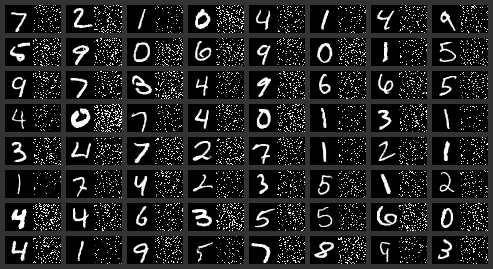

In [77]:
class MNISTPerm:
    class permute(object):
        def __call__(self, tensor):
            out = tensor.flatten()
            out = out[self.perm]
            return out.view(1, 28, 28)

        def __repr__(self):
            return self.__class__.__name__

    def __init__(self, seed=0):
        super(MNISTPerm, self).__init__()
        
        data_root = "mnist"
        self.permuter = self.permute()
        self.seed = seed
        train_dataset = torchvision.datasets.MNIST(
            data_root,
            train=True,
            download=True,
            transform=torchvision.transforms.Compose(
                [
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    self.permuter,
                ]
            ),
        )

        # Data loading code
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=128, shuffle=True
        )
        self.val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                data_root,
                train=False,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                        self.permuter,
                    ]
                ),
            ),
            batch_size=128,
            shuffle=False,
        )

    def update_task(self, i):
        np.random.seed(i + self.seed)
        self.permuter.__setattr__("perm", np.random.permutation(784))
    
    def unpermute(self):
        self.permuter.__setattr__("perm", np.arange(784))

mnist = MNISTPerm()

# Showing some example images from MNISTPerm
mnist.unpermute()
batch, labels = next(iter(mnist.val_loader))

mnist.update_task(0)
task0, labels = next(iter(mnist.val_loader))

torchvision.transforms.ToPILImage()(
    torchvision.utils.make_grid(
        torch.cat([batch, task0], dim=-1)[:64],
        normalize=True,
        padding=5,
        pad_value=0.2
    )
)

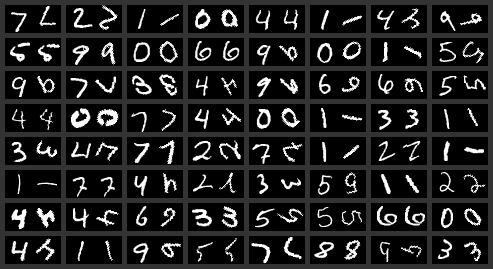

In [87]:
import random

class MNISTRot:
    class rot(object):
        def __call__(self, img):
            if self.rotate:
                return torchvision.transforms.RandomRotation(270)(img)
            return img

        def __repr__(self):
            return self.__class__.__name__

    def __init__(self, seed=0):
        super(MNISTRot, self).__init__()
        
        data_root = "mnist"
        self.seed = seed
        self.rotator = self.rot()
        train_dataset = torchvision.datasets.MNIST(
            data_root,
            train=True,
            download=True,
            transform=torchvision.transforms.Compose(
                [
                    self.rotator,
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                ]
            ),
        )

        # Data loading code
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=128, shuffle=True
        )
        self.val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                data_root,
                train=False,
                transform=torchvision.transforms.Compose(
                     [
                         self.rotator,
                         torchvision.transforms.ToTensor(),
                         torchvision.transforms.Normalize((0.1307,), (0.3081,))
                     ]
                 ),
            ),
            batch_size=128,
            shuffle=False,
        )

    def update_task(self, i):
        random.seed(i + self.seed)
        self.rotator.__setattr__("rotate", True)
    
    def unrotate(self):
        self.rotator.__setattr__("rotate", False)

mnist_rot = MNISTRot()

# Showing some example images from MNISTPerm
mnist_rot.unrotate()
batch, labels = next(iter(mnist_rot.val_loader))

mnist_rot.update_task(0)
task0, labels = next(iter(mnist_rot.val_loader))

torchvision.transforms.ToPILImage()(
    torchvision.utils.make_grid(
        torch.cat([batch, task0], dim=-1)[:64],
        normalize=True,
        padding=5,
        pad_value=0.2
    )
)

### Simple train and evaluation loops for classification

In [79]:
# Finding supermasks per task

def train(model, trainloader, optimizer, epoch):
    model.train()

    criterion = nn.CrossEntropyLoss()
    num_correct = 0
    total_seen = 0
    for i, (batch, labels) in tqdm(
        enumerate(trainloader),
        ascii=True,
        total=len(trainloader)
    ):
        logits = model(batch)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            predictions = logits.argmax(dim=-1)
            num_correct += (predictions == labels).float().sum()
            total_seen += logits.size(0) 
            tqdm.write(
                (f"e{epoch} {i+1}/{len(trainloader)}"
                f" => Loss {loss.item():0.4f}, "
                f"Acc@1 {(num_correct / total_seen):0.4f}"),
                end="\r"
            )


@torch.no_grad()
def evaluate(model, val_loader, epoch):
    model.eval()
    num_correct = 0
    total_seen = 0
    for batch, labels in tqdm(
        val_loader,
        ascii=True,
        total=len(val_loader)
    ):
        logits = model(batch)
        predictions = logits.argmax(dim=-1)
        num_correct += (predictions == labels).float().sum()
        total_seen += logits.size(0) 
    

    tqdm.write(
        f"Val Perf after {epoch + 1} epochs "
        f"Acc@1 {(num_correct / total_seen):0.4f}", 
    )
    return num_correct / total_seen



For any scenario where task ID is given during train time, we simply train each supermask independently, one per task. We make use of our utility function `set_model_task` to do this. We use 5 tasks for demonstration purposes. Feel free to increase `num_tasks` in the following cell. In our paper we use as many as 2500 tasks with no drop in performance for either task inference or validation accuracy.

In [80]:
performance_map = {}

In [81]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
model = MultitaskFC(hidden_size=300, num_tasks=num_tasks)

for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in model.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(model, mnist.val_loader, e)
        
    
    cache_masks(model)
    print()
    set_num_tasks_learned(model, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3408, Acc@1 0.8434


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9295
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3102, Acc@1 0.8564


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9266
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2391, Acc@1 0.8480


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9264
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2603, Acc@1 0.8561


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9247
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3563, Acc@1 0.8522


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9281
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2611, Acc@1 0.8594


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9229
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2415, Acc@1 0.8659


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9262
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2871, Acc@1 0.8623


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9242
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3398, Acc@1 0.8477


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9263
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.1636, Acc@1 0.8590


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9262
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9255778
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2556, Acc@1 0.8464


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9287
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3549, Acc@1 0.8532


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9242
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2233, Acc@1 0.8438


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9277
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4212, Acc@1 0.8535


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9236
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [82]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(model, task)
    mnist.update_task(task)
    acc1 = evaluate(model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.9260
Per task performance
Task 0: 0.9295
Task 1: 0.9266
Task 2: 0.9264
Task 3: 0.9247
Task 4: 0.9281
Task 5: 0.9229
Task 6: 0.9262
Task 7: 0.9242
Task 8: 0.9263
Task 9: 0.9262
Task 10: 0.9243
Task 11: 0.9255
Task 12: 0.9255
Task 13: 0.9287
Task 14: 0.9242
Task 15: 0.9277
Task 16: 0.9236
Task 17: 0.9266
Task 18: 0.9224
Task 19: 0.9300


In [83]:
performance_map['supsup_mnist'] = gg_performance.copy()

### MNIST Perm with Sparsity

In [84]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
models = MultitaskFCSparse(hidden_size=300, num_tasks=num_tasks, sparsity=0.25)

for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(models, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in models.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(models, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(models, mnist.val_loader, e)
        
    
    cache_masks(models)
    print()
    set_num_tasks_learned(models, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2830, Acc@1 0.8398


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9116
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3703, Acc@1 0.8431


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9166
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2802, Acc@1 0.8385


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9111
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3283, Acc@1 0.8421


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9166
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Val Perf after 1 epochs Acc@1 0.9108
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2399, Acc@1 0.8405


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9127
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3334, Acc@1 0.8350


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9135
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [85]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(models, task)
    mnist.update_task(task)
    acc1 = evaluate(models, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.9123
Per task performance
Task 0: 0.9116
Task 1: 0.9166
Task 2: 0.9111
Task 3: 0.9166
Task 4: 0.9125
Task 5: 0.9125
Task 6: 0.9131
Task 7: 0.9119
Task 8: 0.9126
Task 9: 0.9058
Task 10: 0.9093
Task 11: 0.9108
Task 12: 0.9127
Task 13: 0.9135
Task 14: 0.9118
Task 15: 0.9123
Task 16: 0.9130
Task 17: 0.9120
Task 18: 0.9134
Task 19: 0.9134


In [86]:
performance_map['supsup_mnist_sparsity_25'] = gg_performance.copy()

### MNIST Rotated

In [ ]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
model_rot = MultitaskFC(hidden_size=300, num_tasks=num_tasks)

for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model_rot, task)
    mnist_rot.update_task(task)

    optimizer = optim.RMSprop([p for p in model_rot.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model_rot, mnist_rot.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(model_rot, mnist_rot.val_loader, e)
        
    
    cache_masks(model_rot)
    print()
    set_num_tasks_learned(model_rot, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1026, Acc@1 0.5319


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6489
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2014, Acc@1 0.5283


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6528
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1272, Acc@1 0.5371


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6497
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1070, Acc@1 0.5426


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6420
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2219, Acc@1 0.5469


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6487
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2437, Acc@1 0.5423


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6494
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(model_rot, task)
    mnist_rot.update_task(task)
    acc1 = evaluate(model_rot, mnist_rot.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

In [ ]:
performance_map['supsup_mnist_rot'] = gg_performance.copy()

# Basis Masks 

### Model Initialization (Only New Tasks)

In [ ]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [ ]:
seed_dict = model.state_dict()
basis_dict = basis_model.state_dict()
load_dict = {k: seed_dict[k] for k in basis_model.state_dict().keys() if k in seed_dict.keys()}
basis_dict.update(load_dict)
basis_model.load_state_dict(basis_dict, False)
cache_masks(basis_model)

In [ ]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model, mnist.val_loader, e)
        
    
    cache_masks(basis_model)
    print()
    set_num_tasks_learned(basis_model, task + 1)
    print()

In [ ]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

In [ ]:
performance_map['basis_mnist'] = gg_performance.copy()

### Model Initialization (Only New Tasks) Sparsity Enabled

In [ ]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_models = BasisSparseMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, sparsity=0.25, start_at_optimal=True)

In [ ]:
seed_dict = models.state_dict()
basis_dict = basis_models.state_dict()
load_dict = {k: seed_dict[k] for k in basis_models.state_dict().keys() if k in seed_dict.keys()}
basis_dict.update(load_dict)
basis_models.load_state_dict(basis_dict, False)
cache_masks(basis_models)

In [ ]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_models, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_models.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_models, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_models, mnist.val_loader, e)
        
    
    cache_masks(basis_models)
    print()
    set_num_tasks_learned(basis_models, task + 1)
    print()

In [ ]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_models, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_models, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

In [ ]:
performance_map['basis_mnist_sparsity_25'] = gg_performance.copy()

### Model Initialization (Only New Tasks, Rotation MNIST)

In [ ]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_rot = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [ ]:
seed_dictr = model_rot.state_dict()
basis_dictr = basis_model_rot.state_dict()
load_dictr = {k: seed_dictr[k] for k in basis_model_rot.state_dict().keys() if k in seed_dictr.keys()}
basis_dictr.update(load_dictr)
basis_model_rot.load_state_dict(basis_dictr, False)
cache_masks(basis_model_rot)

In [ ]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_rot, task)
    mnist_rot.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_rot.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_rot, mnist_rot.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_rot, mnist_rot.val_loader, e)
        
    
    cache_masks(basis_model_rot)
    print()
    set_num_tasks_learned(basis_model_rot, task + 1)
    print()

In [ ]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_rot, task)
    mnist_rot.update_task(task)
    acc1 = evaluate(basis_model_rot, mnist_rot.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

In [ ]:
performance_map['basis_mnist_rot'] = gg_performance.copy()

## Except Final Layer

### Model Initialization (Only New Tasks)

In [ ]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_hid = BasisHiddenOnlyMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [ ]:
seed_dict_hid = model.state_dict()
basis_dict_hid = basis_model_hid.state_dict()
load_dict_hid = {k: seed_dict_hid[k] for k in basis_model_hid.state_dict().keys() if k in seed_dict_hid.keys()}
basis_dict_hid.update(load_dict_hid)
basis_model_hid.load_state_dict(basis_dict_hid, False)
cache_masks(basis_model_hid)

In [ ]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hid, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hid.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(3):
        train(basis_model_hid, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hid, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hid)
    print()
    set_num_tasks_learned(basis_model_hid, task + 1)
    print()

In [ ]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hid, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hid, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

In [ ]:
performance_map['basis_hybrid_mnist'] = gg_performance.copy()

### Model Initialization (Only New Tasks) Sparsity Enabled

In [117]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_hids = BasisHiddenOnlySparseMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [118]:
seed_dict_hid = models.state_dict()
basis_dict_hid = basis_model_hids.state_dict()
load_dict_hid = {k: seed_dict_hid[k] for k in basis_model_hids.state_dict().keys() if k in seed_dict_hid.keys()}
basis_dict_hid.update(load_dict_hid)
basis_model_hids.load_state_dict(basis_dict_hid, False)
cache_masks(basis_model_hids)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [119]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hids, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hids.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_hids, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hids, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hids)
    print()
    set_num_tasks_learned(basis_model_hids, task + 1)
    print()

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9486, Acc@1 0.6442


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7806


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.6577, Acc@1 0.7383


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7257
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2357, Acc@1 0.6048


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7068


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9058, Acc@1 0.6950


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6946
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7452, Acc@1 0.6458


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7472


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6034, Acc@1 0.7477


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7418
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.0417, Acc@1 0.6214


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6675


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1832, Acc@1 0.6865


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7656
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9743, Acc@1 0.6370


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7769


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9557, Acc@1 0.7396


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7597
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [120]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hids, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hids, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.8685
Per task performance
Task 0: 0.9116
Task 1: 0.9166
Task 2: 0.9111
Task 3: 0.9166
Task 4: 0.9125
Task 5: 0.9125
Task 6: 0.9131
Task 7: 0.9119
Task 8: 0.9126
Task 9: 0.9058
Task 10: 0.9093
Task 11: 0.9108
Task 12: 0.9127
Task 13: 0.9135
Task 14: 0.9118
Task 15: 0.7257
Task 16: 0.6946
Task 17: 0.7418
Task 18: 0.7656
Task 19: 0.7597


In [121]:
performance_map['basis_hybrid_mnist_sparsity_25'] = gg_performance.copy()

### Model Initialization (Only New Tasks, Rotation MNIST)

In [122]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_roth = BasisHiddenOnlyMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [123]:
seed_dictr = model_rot.state_dict()
basis_dictrh = basis_model_roth.state_dict()
load_dictrh = {k: seed_dictr[k] for k in basis_model_roth.state_dict().keys() if k in seed_dictr.keys()}
basis_dictrh.update(load_dictrh)
basis_model_roth.load_state_dict(basis_dictrh, False)
cache_masks(basis_model_roth)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [124]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_roth, task)
    mnist_rot.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_roth.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(3):
        train(basis_model_roth, mnist_rot.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_roth, mnist_rot.val_loader, e)
        
    
    cache_masks(basis_model_roth)
    print()
    set_num_tasks_learned(basis_model_roth, task + 1)
    print()

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5047, Acc@1 0.4681


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5270


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1133, Acc@1 0.5400


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5896


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1454, Acc@1 0.5791


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6195
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1746, Acc@1 0.4743


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5304


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1109, Acc@1 0.5924


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5690


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2276, Acc@1 0.5807


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.6131
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.5711, Acc@1 0.4574


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5098


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3492, Acc@1 0.5127


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.4823


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2600, Acc@1 0.5137


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.4934
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.6396, Acc@1 0.4854


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5021


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3288, Acc@1 0.5072


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5642


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3338, Acc@1 0.5475


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.5563
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3448, Acc@1 0.4518


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.5545


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3816, Acc@1 0.5358


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.5599


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2830, Acc@1 0.5358


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 3 epochs Acc@1 0.5938
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [125]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_roth, task)
    mnist_rot.update_task(task)
    acc1 = evaluate(basis_model_roth, mnist_rot.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.6299
Per task performance
Task 0: 0.6406
Task 1: 0.6466
Task 2: 0.6469
Task 3: 0.6428
Task 4: 0.6543
Task 5: 0.6528
Task 6: 0.6538
Task 7: 0.6475
Task 8: 0.6346
Task 9: 0.6585
Task 10: 0.6547
Task 11: 0.6553
Task 12: 0.6446
Task 13: 0.6526
Task 14: 0.6456
Task 15: 0.6185
Task 16: 0.6123
Task 17: 0.4920
Task 18: 0.5514
Task 19: 0.5917


In [126]:
performance_map['basis_hybrid_mnist_rot'] = gg_performance.copy()

In [128]:
performance_map.keys()

dict_keys(['supsup_mnist', 'supsup_mnist_sparsity_25', 'supsup_mnist_rot', 'basis_mnist', 'basis_mnist_sparsity_25', 'basis_mnist_rot', 'basis_hybrid_mnist', 'basis_hybrid_mnist_sparsity_25', 'basis_hybrid_mnist_rot'])

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [317]:
df = pd.DataFrame(performance_map)

In [318]:
df.loc[:14, 'Seen'] = True
df.loc[15:, 'Seen'] = False

In [319]:
df[[c for c in df.columns if not 'rot' in c]].reset_index().rename(columns={'index': 'Task'}).set_index('Task').style.background_gradient(low=df.min().min(), high=df.max().max(), axis=1)

,supsup_mnist,supsup_mnist_sparsity_25,basis_mnist,basis_mnist_sparsity_25,basis_hybrid_mnist,basis_hybrid_mnist_sparsity_25,basis_hybrid_mnist_frozen,basis_hybrid_mnist_frozen_sparsity25,basis_mnist_task_zero_only,basis_mnist_task_zero_only_sparsity_25,basis_mnist_task_zero_only_hidden_sparsity_25,Seen
Task,,,,,,,,,,,,
0,0.929500,0.911600,0.929500,0.911600,0.929500,0.911600,0.727900,0.127700,0.000000,0.002200,0.002700,True
1,0.926600,0.916600,0.926600,0.916600,0.926600,0.916600,0.923200,0.910100,0.001400,0.003700,0.027000,True
2,0.926400,0.911100,0.926400,0.911100,0.926400,0.911100,0.735400,0.126300,0.005600,0.014300,0.014300,True
3,0.924700,0.916600,0.924700,0.916600,0.924700,0.916600,0.715700,0.146200,0.064800,0.001600,0.000100,True
4,0.928100,0.912500,0.928100,0.912500,0.928100,0.912500,0.747100,0.167300,0.001700,0.008400,0.005400,True
5,0.922900,0.912500,0.922900,0.912500,0.922900,0.912500,0.720000,0.139900,0.002300,0.000100,0.009800,True
6,0.926200,0.913100,0.926200,0.913100,0.926200,0.913100,0.754300,0.186500,0.024500,0.000700,0.010800,True
7,0.924200,0.911900,0.924200,0.911900,0.924200,0.911900,0.729800,0.139900,0.005600,0.003000,0.000500,True
8,0.926300,0.912600,0.926300,0.912600,0.926300,0.912600,0.747000,0.207500,0.012100,0.018400,0.002900,True


In [98]:
df[[c for c in df.columns if 'rot' in c] + ['Seen']].reset_index().rename(columns={'index': 'Task'}).set_index('Task').style.background_gradient(low=df.min().min(), high=df.max().max(), axis=1)

,supsup_mnist_rot,basis_mnist_rot,basis_hybrid_mnist_rot,Seen
Task,,,,
0,0.776300,0.776300,0.776300,True
1,0.779800,0.779800,0.779800,True
2,0.783900,0.783900,0.783900,True
3,0.771300,0.771300,0.771300,True
4,0.762600,0.762600,0.762600,True
5,0.772700,0.772700,0.772700,True
6,0.782200,0.782200,0.782200,True
7,0.775200,0.775200,0.775200,True
8,0.785200,0.785200,0.785200,True


### Model Initialization (Cross task analysts, retraining last layer) -- Using mask from task 1

In [133]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_hidf = BasisHiddenOnlyFrozenMultitaskFC(hidden_size=300,
                            num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [134]:
custom_state_dict = basis_model_hidf.state_dict().copy()
custom_state_dict.update({k:v for k,v in model.state_dict().items() if k in custom_state_dict.keys()})

In [135]:
for k in custom_state_dict.keys():
    if k.startswith('model.0.scores.'):
        custom_state_dict[k] = model.state_dict()['model.0.scores.1']
    elif k.startswith('model.2.scores.'):
        custom_state_dict[k] = model.state_dict()['model.2.scores.1']
    elif k.startswith('model.0.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.0.basis_alphas.1'] 
    elif k.startswith('model.2.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.2.basis_alphas.1']

In [137]:
basis_model_hidf.load_state_dict(custom_state_dict, False)
cache_masks(basis_model_hidf)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [138]:
for task in range(0, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hidf, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hidf.parameters() if p.requires_grad], lr=1e-3)
    # Train for 1 epoch
    for e in range(1):
        train(basis_model_hidf, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hidf, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hidf)
    print()
    set_num_tasks_learned(basis_model_hidf, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3659, Acc@1 0.6859


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7279
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3937, Acc@1 0.9176


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9232
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3747, Acc@1 0.6618


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7354
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.4363, Acc@1 0.6738


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7157
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1674, Acc@1 0.6934


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7471
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3776, Acc@1 0.6852


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7200
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3697, Acc@1 0.7106


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7543
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3089, Acc@1 0.6768


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7298
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2656, Acc@1 0.6865


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7470
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3775, Acc@1 0.6908


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7378
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3209, Acc@1 0.7008


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7478
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 11
=> Setting learned tasks of model.2 to 11
=> Setting learned tasks of model.4 to 11

Training for task 11
=> Set task of model.0 to 11
=> Set task of model.2 to 11
=> Set task of model.4 to 11


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2105, Acc@1 0.6953


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7471
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2974, Acc@1 0.6846


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7404
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3349, Acc@1 0.6699


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7075
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3001, Acc@1 0.6862


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7410
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3483, Acc@1 0.6693


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7149
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3433, Acc@1 0.6706


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7516
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3107, Acc@1 0.6950


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7516
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3609, Acc@1 0.6810


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7169
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.3019, Acc@1 0.6917


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7613
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [139]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hidf, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hidf, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.7459
Per task performance
Task 0: 0.7279
Task 1: 0.9232
Task 2: 0.7354
Task 3: 0.7157
Task 4: 0.7471
Task 5: 0.7200
Task 6: 0.7543
Task 7: 0.7298
Task 8: 0.7470
Task 9: 0.7378
Task 10: 0.7478
Task 11: 0.7471
Task 12: 0.7404
Task 13: 0.7075
Task 14: 0.7410
Task 15: 0.7149
Task 16: 0.7516
Task 17: 0.7516
Task 18: 0.7169
Task 19: 0.7613


In [140]:
performance_map['basis_hybrid_mnist_frozen'] = gg_performance.copy()

### Model Initialization (Cross task analysis, retraining last layer) -- Using mask from task 1, Sparsity 25

In [148]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_hidfs = BasisHiddenOnlySparseFrozenMultitaskFC(hidden_size=300,
                            num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, sparsity=0.25, start_at_optimal=True,)

In [149]:
custom_state_dict = basis_model_hidfs.state_dict().copy()
custom_state_dict.update({k:v for k,v in models.state_dict().items() if k in custom_state_dict.keys()})

In [150]:
for k in custom_state_dict.keys():
    if k.startswith('model.0.scores.'):
        custom_state_dict[k] = models.state_dict()['model.0.scores.1']
    elif k.startswith('model.2.scores.'):
        custom_state_dict[k] = models.state_dict()['model.2.scores.1']
    elif k.startswith('model.0.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.0.basis_alphas.1'] 
    elif k.startswith('model.2.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.2.basis_alphas.1']

In [151]:
basis_model_hidfs.load_state_dict(custom_state_dict, False)
cache_masks(basis_model_hidfs)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [152]:
for task in range(0, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_hidfs, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_hidfs.parameters() if p.requires_grad], lr=1e-3)
    # Train for 1 epoch
    for e in range(1):
        train(basis_model_hidfs, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_hidfs, mnist.val_loader, e)
        
    
    cache_masks(basis_model_hidfs)
    print()
    set_num_tasks_learned(basis_model_hidfs, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.7949, Acc@1 0.2321


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1277
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2193, Acc@1 0.9085


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9101
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0700, Acc@1 0.2096


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1263
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8840, Acc@1 0.2051


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1462
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.7379, Acc@1 0.2620


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1673
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0438, Acc@1 0.2386


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1399
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8774, Acc@1 0.2490


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1865
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7

Training for task 7
=> Set task of model.0 to 7
=> Set task of model.2 to 7
=> Set task of model.4 to 7


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0601, Acc@1 0.2380


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1399
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 8
=> Setting learned tasks of model.2 to 8
=> Setting learned tasks of model.4 to 8

Training for task 8
=> Set task of model.0 to 8
=> Set task of model.2 to 8
=> Set task of model.4 to 8


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.9645, Acc@1 0.2562


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2075
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 9
=> Setting learned tasks of model.2 to 9
=> Setting learned tasks of model.4 to 9

Training for task 9
=> Set task of model.0 to 9
=> Set task of model.2 to 9
=> Set task of model.4 to 9


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8566, Acc@1 0.2057


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1312
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 10
=> Setting learned tasks of model.2 to 10
=> Setting learned tasks of model.4 to 10

Training for task 10
=> Set task of model.0 to 10
=> Set task of model.2 to 10
=> Set task of model.4 to 10


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0359, Acc@1 0.2523


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1916
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 11
=> Setting learned tasks of model.2 to 11
=> Setting learned tasks of model.4 to 11

Training for task 11
=> Set task of model.0 to 11
=> Set task of model.2 to 11
=> Set task of model.4 to 11


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0021, Acc@1 0.2122


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1515
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 12
=> Setting learned tasks of model.2 to 12
=> Setting learned tasks of model.4 to 12

Training for task 12
=> Set task of model.0 to 12
=> Set task of model.2 to 12
=> Set task of model.4 to 12


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0505, Acc@1 0.2178


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1314
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 13
=> Setting learned tasks of model.2 to 13
=> Setting learned tasks of model.4 to 13

Training for task 13
=> Set task of model.0 to 13
=> Set task of model.2 to 13
=> Set task of model.4 to 13


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0472, Acc@1 0.2930


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2359
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 14
=> Setting learned tasks of model.2 to 14
=> Setting learned tasks of model.4 to 14

Training for task 14
=> Set task of model.0 to 14
=> Set task of model.2 to 14
=> Set task of model.4 to 14


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0947, Acc@1 0.2178


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1894
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 15
=> Setting learned tasks of model.2 to 15
=> Setting learned tasks of model.4 to 15

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0573, Acc@1 0.2038


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1684
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.7659, Acc@1 0.2484


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1761
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.9463, Acc@1 0.2057


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1725
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0789, Acc@1 0.2331


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1807
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.9310, Acc@1 0.2454


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1840
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [153]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hidfs, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hidfs, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.2032
Per task performance
Task 0: 0.1277
Task 1: 0.9101
Task 2: 0.1263
Task 3: 0.1462
Task 4: 0.1673
Task 5: 0.1399
Task 6: 0.1865
Task 7: 0.1399
Task 8: 0.2075
Task 9: 0.1312
Task 10: 0.1916
Task 11: 0.1515
Task 12: 0.1314
Task 13: 0.2359
Task 14: 0.1894
Task 15: 0.1684
Task 16: 0.1761
Task 17: 0.1725
Task 18: 0.1807
Task 19: 0.1840


In [154]:
performance_map['basis_hybrid_mnist_frozen_sparsity25'] = gg_performance.copy()

### Model Initialization (Cross task analysis, no retraining) -- Using mask from task 1

In [158]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_hidf = BasisHiddenOnlyFrozenMultitaskFC(hidden_size=300,
                            num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [159]:
custom_state_dict = basis_model_hidf.state_dict().copy()
custom_state_dict.update({k:v for k,v in model.state_dict().items() if k in custom_state_dict.keys()})

In [160]:
for k in custom_state_dict.keys():
    if k.startswith('model.0.scores.'):
        custom_state_dict[k] = model.state_dict()['model.0.scores.1']
    elif k.startswith('model.2.scores.'):
        custom_state_dict[k] = model.state_dict()['model.2.scores.1']
    elif k.startswith('model.0.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.0.basis_alphas.1'] 
    elif k.startswith('model.2.basis_alphas.'):
        custom_state_dict[k] = custom_state_dict['model.2.basis_alphas.1']

In [161]:
basis_model_hidf.load_state_dict(custom_state_dict, False)
cache_masks(basis_model_hidf)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [162]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_hidf, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_hidf, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.1522
Per task performance
Task 0: 0.1224
Task 1: 0.9266
Task 2: 0.0949
Task 3: 0.0670
Task 4: 0.1245
Task 5: 0.1782
Task 6: 0.1502
Task 7: 0.1269
Task 8: 0.0935
Task 9: 0.1140
Task 10: 0.0936
Task 11: 0.1076
Task 12: 0.0997
Task 13: 0.1127
Task 14: 0.0945
Task 15: 0.0943
Task 16: 0.1285
Task 17: 0.1021
Task 18: 0.1017
Task 19: 0.1111


## Overlap Analysis

In [163]:
mnist1 = MNISTPerm()
mnist2 = MNISTPerm()
mnist3 = MNISTPerm()
mnist4 = MNISTPerm()

In [164]:
weight_dict = {k: v for k,v in model.state_dict().items() if k.endswith('weight')}

In [165]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 5 # For demonstration purposes, we go up to 2500 in our paper
model1 = MultitaskFC(hidden_size=300, num_tasks=num_tasks)
sd1 = model1.state_dict()
sd1.update(weight_dict)
model1.load_state_dict(sd1)
model2 = MultitaskFC(hidden_size=300, num_tasks=num_tasks)
sd2 = model2.state_dict()
sd2.update(weight_dict)
model2.load_state_dict(sd2)
model3 = MultitaskFC(hidden_size=300, num_tasks=num_tasks)
sd3 = model3.state_dict()
sd3.update(weight_dict)
model3.load_state_dict(sd3)

<All keys matched successfully>

In [166]:
for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model1, task)
    set_model_task(model2, task)
    set_model_task(model3, task)
    mnist1.update_task(task)
    mnist2.update_task(task)
    mnist3.update_task(task)

    optimizer1 = optim.RMSprop([p for p in model1.parameters() if p.requires_grad], lr=1e-4)
    optimizer2 = optim.RMSprop([p for p in model2.parameters() if p.requires_grad], lr=1e-4)
    optimizer3 = optim.RMSprop([p for p in model3.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model1, mnist1.train_loader, optimizer1, e)
        train(model2, mnist2.train_loader, optimizer2, e)
        train(model3, mnist3.train_loader, optimizer3, e)

#         print("Validation")
#         print("============")
#         acc1 = evaluate(model, mnist.val_loader, e)


    cache_masks(model1)
    cache_masks(model2)
    cache_masks(model3)
    print()
    set_num_tasks_learned(model1, task + 1)
    set_num_tasks_learned(model2, task + 1)
    set_num_tasks_learned(model3, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8496
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1
=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1
=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8522
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2
=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2
=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8577
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3
=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3
=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8639
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4
=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4
=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8594
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5
=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5
=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5



In [167]:
def overlap(mask1, mask2):
    assert mask1.shape == mask2.shape
    count_same = (mask1 + mask2 - 1).abs().sum()
    return count_same / (1.0*(mask1.shape[0] * mask1.shape[1]))

In [168]:
from itertools import product

In [169]:
for layer, task in product([0,2,4], [i for i in range(5)]):
    print('Layer: {}, Task: {}, Overlap: {}'.format(layer, task,
        overlap(model2.state_dict()['model.{}.stacked'.format(layer)][task],
                model3.state_dict()['model.{}.stacked'.format(layer)][task])))

Layer: 0, Task: 0, Overlap: 0.51096510887146
Layer: 0, Task: 1, Overlap: 0.5155952572822571
Layer: 0, Task: 2, Overlap: 0.5139200687408447
Layer: 0, Task: 3, Overlap: 0.5134651064872742
Layer: 0, Task: 4, Overlap: 0.5120918154716492
Layer: 2, Task: 0, Overlap: 0.503944456577301
Layer: 2, Task: 1, Overlap: 0.5013333559036255
Layer: 2, Task: 2, Overlap: 0.5013222098350525
Layer: 2, Task: 3, Overlap: 0.50445556640625
Layer: 2, Task: 4, Overlap: 0.501455545425415
Layer: 4, Task: 0, Overlap: 0.5084999799728394
Layer: 4, Task: 1, Overlap: 0.5153999924659729
Layer: 4, Task: 2, Overlap: 0.5112333297729492
Layer: 4, Task: 3, Overlap: 0.5065333247184753
Layer: 4, Task: 4, Overlap: 0.5167333483695984


## Overlap Analysis with Sparsity (25%)

In [170]:
mnist1 = MNISTPerm()
mnist2 = MNISTPerm()
mnist3 = MNISTPerm()
mnist4 = MNISTPerm()

In [171]:
weight_dict = {k: v for k,v in models.state_dict().items() if k.endswith('weight')}

In [172]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 5 # For demonstration purposes, we go up to 2500 in our paper
model1 = MultitaskFCSparse(hidden_size=300, num_tasks=num_tasks, sparsity=0.25)
sd1 = model1.state_dict()
sd1.update(weight_dict)
model1.load_state_dict(sd1)
model2 = MultitaskFCSparse(hidden_size=300, num_tasks=num_tasks, sparsity=0.25)
sd2 = model2.state_dict()
sd2.update(weight_dict)
model2.load_state_dict(sd2)
model3 = MultitaskFCSparse(hidden_size=300, num_tasks=num_tasks, sparsity=0.25)
sd3 = model3.state_dict()
sd3.update(weight_dict)
model3.load_state_dict(sd3)

<All keys matched successfully>

In [173]:
for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model1, task)
    set_model_task(model2, task)
    set_model_task(model3, task)
    mnist1.update_task(task)
    mnist2.update_task(task)
    mnist3.update_task(task)

    optimizer1 = optim.RMSprop([p for p in model1.parameters() if p.requires_grad], lr=1e-4)
    optimizer2 = optim.RMSprop([p for p in model2.parameters() if p.requires_grad], lr=1e-4)
    optimizer3 = optim.RMSprop([p for p in model3.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model1, mnist1.train_loader, optimizer1, e)
        train(model2, mnist2.train_loader, optimizer2, e)
        train(model3, mnist3.train_loader, optimizer3, e)

#         print("Validation")
#         print("============")
#         acc1 = evaluate(model, mnist.val_loader, e)


    cache_masks(model1)
    cache_masks(model2)
    cache_masks(model3)
    print()
    set_num_tasks_learned(model1, task + 1)
    set_num_tasks_learned(model2, task + 1)
    set_num_tasks_learned(model3, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8356
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1
=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1
=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8291
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2
=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2
=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8438
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3
=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3
=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8369
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4
=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4
=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.8395
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5
=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5
=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5



In [174]:
def overlap(mask1, mask2):
    assert mask1.shape == mask2.shape
    count_same = (mask1 + mask2 - 1).abs().sum()
    return count_same / (1.0*(mask1.shape[0] * mask1.shape[1]))

In [175]:
from itertools import product

In [176]:
for layer, task in product([0,2,4], [i for i in range(5)]):
    print('Layer: {}, Task: {}, Overlap: {}'.format(layer, task,
        overlap(model2.state_dict()['model.{}.stacked'.format(layer)][task],
                model3.state_dict()['model.{}.stacked'.format(layer)][task])))

Layer: 0, Task: 0, Overlap: 0.6428911685943604
Layer: 0, Task: 1, Overlap: 0.6420833468437195
Layer: 0, Task: 2, Overlap: 0.6420493125915527
Layer: 0, Task: 3, Overlap: 0.6426190733909607
Layer: 0, Task: 4, Overlap: 0.6432312726974487
Layer: 2, Task: 0, Overlap: 0.6288444399833679
Layer: 2, Task: 1, Overlap: 0.6273333430290222
Layer: 2, Task: 2, Overlap: 0.6287555694580078
Layer: 2, Task: 3, Overlap: 0.6279555559158325
Layer: 2, Task: 4, Overlap: 0.627488911151886
Layer: 4, Task: 0, Overlap: 0.6443333625793457
Layer: 4, Task: 1, Overlap: 0.6440666913986206
Layer: 4, Task: 2, Overlap: 0.6439999938011169
Layer: 4, Task: 3, Overlap: 0.6449333429336548
Layer: 4, Task: 4, Overlap: 0.642799973487854


## Overlap Analysis with Sparsity (5%)

In [177]:
mnist1 = MNISTPerm()
mnist2 = MNISTPerm()
mnist3 = MNISTPerm()
mnist4 = MNISTPerm()

In [178]:
weight_dict = {k: v for k,v in models.state_dict().items() if k.endswith('weight')}

In [179]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 5 # For demonstration purposes, we go up to 2500 in our paper
model1 = MultitaskFCSparse(hidden_size=300, num_tasks=num_tasks, sparsity=0.05)
sd1 = model1.state_dict()
sd1.update(weight_dict)
model1.load_state_dict(sd1)
model2 = MultitaskFCSparse(hidden_size=300, num_tasks=num_tasks, sparsity=0.05)
sd2 = model2.state_dict()
sd2.update(weight_dict)
model2.load_state_dict(sd2)
model3 = MultitaskFCSparse(hidden_size=300, num_tasks=num_tasks, sparsity=0.05)
sd3 = model3.state_dict()
sd3.update(weight_dict)
model3.load_state_dict(sd3)

<All keys matched successfully>

In [180]:
for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model1, task)
    set_model_task(model2, task)
    set_model_task(model3, task)
    mnist1.update_task(task)
    mnist2.update_task(task)
    mnist3.update_task(task)

    optimizer1 = optim.RMSprop([p for p in model1.parameters() if p.requires_grad], lr=1e-4)
    optimizer2 = optim.RMSprop([p for p in model2.parameters() if p.requires_grad], lr=1e-4)
    optimizer3 = optim.RMSprop([p for p in model3.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model1, mnist1.train_loader, optimizer1, e)
        train(model2, mnist2.train_loader, optimizer2, e)
        train(model3, mnist3.train_loader, optimizer3, e)

#         print("Validation")
#         print("============")
#         acc1 = evaluate(model, mnist.val_loader, e)


    cache_masks(model1)
    cache_masks(model2)
    cache_masks(model3)
    print()
    set_num_tasks_learned(model1, task + 1)
    set_num_tasks_learned(model2, task + 1)
    set_num_tasks_learned(model3, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.3001
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1
=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1
=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.3900
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2
=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2
=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.3307
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3
=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3
=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.3190
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4
=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4
=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

=> Caching mask state for model.00.3981
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5
=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5
=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5



In [181]:
def overlap(mask1, mask2):
    assert mask1.shape == mask2.shape
    count_same = (mask1 + mask2 - 1).abs().sum()
    return count_same / (1.0*(mask1.shape[0] * mask1.shape[1]))

In [182]:
from itertools import product

In [183]:
for layer, task in product([0,2,4], [i for i in range(5)]):
    print('Layer: {}, Task: {}, Overlap: {}'.format(layer, task,
        overlap(model2.state_dict()['model.{}.stacked'.format(layer)][task],
                model3.state_dict()['model.{}.stacked'.format(layer)][task])))

Layer: 0, Task: 0, Overlap: 0.912508487701416
Layer: 0, Task: 1, Overlap: 0.9120748043060303
Layer: 0, Task: 2, Overlap: 0.9122363924980164
Layer: 0, Task: 3, Overlap: 0.912295937538147
Layer: 0, Task: 4, Overlap: 0.9120323061943054
Layer: 2, Task: 0, Overlap: 0.9100444316864014
Layer: 2, Task: 1, Overlap: 0.9103778004646301
Layer: 2, Task: 2, Overlap: 0.9103555679321289
Layer: 2, Task: 3, Overlap: 0.9097777605056763
Layer: 2, Task: 4, Overlap: 0.9114000201225281
Layer: 4, Task: 0, Overlap: 0.9117333292961121
Layer: 4, Task: 1, Overlap: 0.9111999869346619
Layer: 4, Task: 2, Overlap: 0.9112666845321655
Layer: 4, Task: 3, Overlap: 0.9115999937057495
Layer: 4, Task: 4, Overlap: 0.9118666648864746


### Multimask Same Task 

In [203]:
num_masks_to_create = 15

In [204]:
loaders = {}
for i in range(num_masks_to_create):
    loaders[i] = MNISTPerm()

In [205]:
weight_dict = {k: v for k,v in model.state_dict().items() if k.endswith('weight')}

In [206]:
# Task ID given during train time
from IPython.display import clear_output

model_map = {}
for i in range(num_masks_to_create):
    modeli = MultitaskFC(hidden_size=300, num_tasks=1)
    sdi = modeli.state_dict()
    sdi.update(weight_dict)
    modeli.load_state_dict(sdi)
    model_map[i] = modeli

In [207]:
for idx, modeli in model_map.items():
    for task in range(1):
        print(f"Training for task {task}")
        set_model_task(modeli, task)
        mnisti = loaders[idx]
        mnisti.update_task(task)

        optimizer1 = optim.RMSprop([p for p in modeli.parameters() if p.requires_grad], lr=1e-4)
        # Train for 1 epoch
        for e in range(1):
            train(modeli, mnisti.train_loader, optimizer1, e)
            
            print("Validation")
            print("============")
            acc1 = evaluate(modeli, mnisti.val_loader, e)


        cache_masks(modeli)
        print()
        set_num_tasks_learned(modeli, task + 1)
        print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2728, Acc@1 0.8610


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9274
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2012, Acc@1 0.8587


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9257
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4101, Acc@1 0.8499


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9225
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3553, Acc@1 0.8447


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9246
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3421, Acc@1 0.8538


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9259
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2036, Acc@1 0.8493


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9262
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2799, Acc@1 0.8503


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9258
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3788, Acc@1 0.8477


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9254
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3063, Acc@1 0.8633


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9269
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2844, Acc@1 0.8607


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9246
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2708, Acc@1 0.8529


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9239
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2453, Acc@1 0.8525


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9219
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3848, Acc@1 0.8483


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9217
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3255, Acc@1 0.8555


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9239
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3825, Acc@1 0.8473


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9248
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1



In [208]:
def overlap(mask1, mask2):
    assert mask1.shape == mask2.shape
    count_same = (mask1 + mask2 - 1).abs().sum()
    return count_same / (1.0*(mask1.shape[0] * mask1.shape[1]))

In [209]:
from itertools import product

In [212]:
task = 0
for layer, modelidx in product([0,2,4], product([i for i in range(15)], [i for i in range(15)])):
    modeli, modelj = modelidx
    if modeli == modelj:
        continue
    print('Layer: {}, Models: ({}, {}), Overlap: {}'.format(layer, modeli, modelj,
        overlap(model_map[modeli].state_dict()['model.{}.stacked'.format(layer)][task],
                model_map[modelj].state_dict()['model.{}.stacked'.format(layer)][task])))

Layer: 0, Models: (0, 1), Overlap: 0.5137117505073547
Layer: 0, Models: (0, 2), Overlap: 0.5123809576034546
Layer: 0, Models: (0, 3), Overlap: 0.5121513605117798
Layer: 0, Models: (0, 4), Overlap: 0.5120238065719604
Layer: 0, Models: (0, 5), Overlap: 0.5122109055519104
Layer: 0, Models: (0, 6), Overlap: 0.5125425457954407
Layer: 0, Models: (0, 7), Overlap: 0.511126697063446
Layer: 0, Models: (0, 8), Overlap: 0.5117729306221008
Layer: 0, Models: (0, 9), Overlap: 0.5117644667625427
Layer: 0, Models: (0, 10), Overlap: 0.5147448778152466
Layer: 0, Models: (0, 11), Overlap: 0.5122236609458923
Layer: 0, Models: (0, 12), Overlap: 0.51350337266922
Layer: 0, Models: (0, 13), Overlap: 0.5119345188140869
Layer: 0, Models: (0, 14), Overlap: 0.5143027305603027
Layer: 0, Models: (1, 0), Overlap: 0.5137117505073547
Layer: 0, Models: (1, 2), Overlap: 0.5127848386764526
Layer: 0, Models: (1, 3), Overlap: 0.5127848386764526
Layer: 0, Models: (1, 4), Overlap: 0.5139413475990295
Layer: 0, Models: (1, 5), 

Layer: 2, Models: (4, 10), Overlap: 0.505577802658081
Layer: 2, Models: (4, 11), Overlap: 0.5021666884422302
Layer: 2, Models: (4, 12), Overlap: 0.5025110840797424
Layer: 2, Models: (4, 13), Overlap: 0.5019111037254333
Layer: 2, Models: (4, 14), Overlap: 0.5006444454193115
Layer: 2, Models: (5, 0), Overlap: 0.5036333203315735
Layer: 2, Models: (5, 1), Overlap: 0.5020555257797241
Layer: 2, Models: (5, 2), Overlap: 0.5024555325508118
Layer: 2, Models: (5, 3), Overlap: 0.5024333596229553
Layer: 2, Models: (5, 4), Overlap: 0.5020111203193665
Layer: 2, Models: (5, 6), Overlap: 0.5037333369255066
Layer: 2, Models: (5, 7), Overlap: 0.5029110908508301
Layer: 2, Models: (5, 8), Overlap: 0.5046555399894714
Layer: 2, Models: (5, 9), Overlap: 0.503155529499054
Layer: 2, Models: (5, 10), Overlap: 0.5000777840614319
Layer: 2, Models: (5, 11), Overlap: 0.5025333166122437
Layer: 2, Models: (5, 12), Overlap: 0.503433346748352
Layer: 2, Models: (5, 13), Overlap: 0.5032111406326294
Layer: 2, Models: (5, 

### Multimask Same Task (Sparsity 25)

In [213]:
num_masks_to_create = 15

In [214]:
loaders = {}
for i in range(num_masks_to_create):
    loaders[i] = MNISTPerm()

In [215]:
weight_dict = {k: v for k,v in models.state_dict().items() if k.endswith('weight')}

In [216]:
# Task ID given during train time
from IPython.display import clear_output

model_maps = {}
for i in range(num_masks_to_create):
    modeli = MultitaskFCSparse(hidden_size=300, num_tasks=1, sparsity=0.25)
    sdi = modeli.state_dict()
    sdi.update(weight_dict)
    modeli.load_state_dict(sdi)
    model_maps[i] = modeli

In [217]:
for idx, modeli in model_maps.items():
    for task in range(1):
        print(f"Training for task {task}")
        set_model_task(modeli, task)
        mnisti = loaders[idx]
        mnisti.update_task(task)

        optimizer1 = optim.RMSprop([p for p in modeli.parameters() if p.requires_grad], lr=1e-4)
        # Train for 1 epoch
        for e in range(1):
            train(modeli, mnisti.train_loader, optimizer1, e)
            
            print("Validation")
            print("============")
            acc1 = evaluate(modeli, mnisti.val_loader, e)


        cache_masks(modeli)
        print()
        set_num_tasks_learned(modeli, task + 1)
        print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2764, Acc@1 0.8298


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9111
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3107, Acc@1 0.8330


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9105
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2673, Acc@1 0.8320


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9130
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3994, Acc@1 0.8379


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9136
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3628, Acc@1 0.8438


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9119
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3440, Acc@1 0.8298


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9142
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4477, Acc@1 0.8454


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9139
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.2559, Acc@1 0.8467


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9119
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3870, Acc@1 0.8392


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9124
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3584, Acc@1 0.8411


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9079
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3098, Acc@1 0.8350


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9113
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3097, Acc@1 0.8460


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9160
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3899, Acc@1 0.8424


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9115
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.3227, Acc@1 0.8454


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9101
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4783, Acc@1 0.8314


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.9123
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1



In [220]:
task = 0
for layer, modelidx in product([0,2,4], product([i for i in range(15)], [i for i in range(15)])):
    modeli, modelj = modelidx
    if modeli == modelj:
        continue
    print('Layer: {}, Models: ({}, {}), Overlap: {}'.format(layer, modeli, modelj,
        overlap(model_maps[modeli].state_dict()['model.{}.stacked'.format(layer)][task],
                model_maps[modelj].state_dict()['model.{}.stacked'.format(layer)][task])))

Layer: 0, Models: (0, 1), Overlap: 0.6411479711532593
Layer: 0, Models: (0, 2), Overlap: 0.6433843374252319
Layer: 0, Models: (0, 3), Overlap: 0.6438350081443787
Layer: 0, Models: (0, 4), Overlap: 0.6411394476890564
Layer: 0, Models: (0, 5), Overlap: 0.6416326761245728
Layer: 0, Models: (0, 6), Overlap: 0.6418962478637695
Layer: 0, Models: (0, 7), Overlap: 0.6417006850242615
Layer: 0, Models: (0, 8), Overlap: 0.6428826451301575
Layer: 0, Models: (0, 9), Overlap: 0.6420578360557556
Layer: 0, Models: (0, 10), Overlap: 0.6414455771446228
Layer: 0, Models: (0, 11), Overlap: 0.641232967376709
Layer: 0, Models: (0, 12), Overlap: 0.6421173214912415
Layer: 0, Models: (0, 13), Overlap: 0.643562912940979
Layer: 0, Models: (0, 14), Overlap: 0.6414710879325867
Layer: 0, Models: (1, 0), Overlap: 0.6411479711532593
Layer: 0, Models: (1, 2), Overlap: 0.6411224603652954
Layer: 0, Models: (1, 3), Overlap: 0.6421768665313721
Layer: 0, Models: (1, 4), Overlap: 0.6426190733909607
Layer: 0, Models: (1, 5),

Layer: 0, Models: (11, 5), Overlap: 0.6414285898208618
Layer: 0, Models: (11, 6), Overlap: 0.6410544514656067
Layer: 0, Models: (11, 7), Overlap: 0.6402975916862488
Layer: 0, Models: (11, 8), Overlap: 0.6435884237289429
Layer: 0, Models: (11, 9), Overlap: 0.6426870822906494
Layer: 0, Models: (11, 10), Overlap: 0.6432822942733765
Layer: 0, Models: (11, 12), Overlap: 0.6423469185829163
Layer: 0, Models: (11, 13), Overlap: 0.6433843374252319
Layer: 0, Models: (11, 14), Overlap: 0.643146276473999
Layer: 0, Models: (12, 0), Overlap: 0.6421173214912415
Layer: 0, Models: (12, 1), Overlap: 0.6403146386146545
Layer: 0, Models: (12, 2), Overlap: 0.6438605189323425
Layer: 0, Models: (12, 3), Overlap: 0.6404251456260681
Layer: 0, Models: (12, 4), Overlap: 0.6406547427177429
Layer: 0, Models: (12, 5), Overlap: 0.6429761648178101
Layer: 0, Models: (12, 6), Overlap: 0.6417347192764282
Layer: 0, Models: (12, 7), Overlap: 0.6417602300643921
Layer: 0, Models: (12, 8), Overlap: 0.6428061127662659
Layer: 

Layer: 4, Models: (4, 8), Overlap: 0.642799973487854
Layer: 4, Models: (4, 9), Overlap: 0.646399974822998
Layer: 4, Models: (4, 10), Overlap: 0.6416000127792358
Layer: 4, Models: (4, 11), Overlap: 0.6425999999046326
Layer: 4, Models: (4, 12), Overlap: 0.6443333625793457
Layer: 4, Models: (4, 13), Overlap: 0.6402666568756104
Layer: 4, Models: (4, 14), Overlap: 0.6410666704177856
Layer: 4, Models: (5, 0), Overlap: 0.6438000202178955
Layer: 4, Models: (5, 1), Overlap: 0.6439999938011169
Layer: 4, Models: (5, 2), Overlap: 0.6399999856948853
Layer: 4, Models: (5, 3), Overlap: 0.6434000134468079
Layer: 4, Models: (5, 4), Overlap: 0.6435999870300293
Layer: 4, Models: (5, 6), Overlap: 0.6475333571434021
Layer: 4, Models: (5, 7), Overlap: 0.6420000195503235
Layer: 4, Models: (5, 8), Overlap: 0.6407999992370605
Layer: 4, Models: (5, 9), Overlap: 0.6434000134468079
Layer: 4, Models: (5, 10), Overlap: 0.6443333625793457
Layer: 4, Models: (5, 11), Overlap: 0.6435999870300293
Layer: 4, Models: (5, 1

## New Task performance using task 0 masks only!

### Model Initialization (Only New Tasks)

In [271]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_zero = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True)

In [272]:
seed_dict = basis_model_zero.state_dict()

In [273]:
update_dict = seed_dict.copy()

In [274]:
assert all([(model_map[0].state_dict()['model.0.weight'] == model_map[i].state_dict()['model.0.weight']).all() for i in range(1,15)])
update_dict['model.0.weight'] = model_map[0].state_dict()['model.0.weight']
for task in range(15):
    for layer in [0,2,4]:
        update_dict['model.{}.scores.{}'.format(layer, task)] = model_map[task].state_dict()['model.{}.scores.0'.format(layer)]

In [275]:
seed_dict.update(update_dict)
basis_model_zero.load_state_dict(seed_dict, False)
cache_masks(basis_model_zero)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [276]:
num_seed_tasks_learned, num_tasks

(15, 20)

In [277]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_zero, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_zero.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_zero, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_zero, mnist.val_loader, e)
        
    
    cache_masks(basis_model_zero)
    print()
    set_num_tasks_learned(basis_model_zero, task + 1)
    print()

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8492, Acc@1 0.1826


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2111


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.9094, Acc@1 0.1963


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.2073
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8647, Acc@1 0.2272


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2612


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8692, Acc@1 0.2588


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.2557
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0088, Acc@1 0.2031


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2468


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8724, Acc@1 0.2604


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.2442
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8419, Acc@1 0.2070


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2473


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8511, Acc@1 0.2546


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.2527
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.9444, Acc@1 0.1637


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2081


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.3216, Acc@1 0.2191


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.2172
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [278]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_zero, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_zero, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.0688
Per task performance
Task 0: 0.0000
Task 1: 0.0014
Task 2: 0.0056
Task 3: 0.0648
Task 4: 0.0017
Task 5: 0.0023
Task 6: 0.0245
Task 7: 0.0056
Task 8: 0.0121
Task 9: 0.0011
Task 10: 0.0181
Task 11: 0.0012
Task 12: 0.0193
Task 13: 0.0292
Task 14: 0.0117
Task 15: 0.2073
Task 16: 0.2557
Task 17: 0.2442
Task 18: 0.2527
Task 19: 0.2172


In [279]:
performance_map['basis_mnist_task_zero_only'] = gg_performance.copy()

### Model Initialization (Only New Tasks) Sparsity Enabled

In [287]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_zeros = BasisSparseMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=False, sparsity=0.25)

In [288]:
seed_dict = basis_model_zeros.state_dict()

In [289]:
update_dict = seed_dict.copy()

In [290]:
assert all([(model_maps[0].state_dict()['model.0.weight'] == model_maps[i].state_dict()['model.0.weight']).all() for i in range(1,15)])
update_dict['model.0.weight'] = model_map[0].state_dict()['model.0.weight']
for task in range(15):
    for layer in [0,2,4]:
        update_dict['model.{}.scores.{}'.format(layer, task)] = model_maps[task].state_dict()['model.{}.scores.0'.format(layer)]

In [291]:
seed_dict.update(update_dict)
basis_model_zeros.load_state_dict(seed_dict, False)
cache_masks(basis_model_zeros)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [292]:
num_seed_tasks_learned, num_tasks

(15, 20)

In [293]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_zeros, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_zeros.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_zeros, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_zeros, mnist.val_loader, e)
        
    
    cache_masks(basis_model_zeros)
    print()
    set_num_tasks_learned(basis_model_zeros, task + 1)
    print()

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 3.0438, Acc@1 0.2035


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2395


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.9901, Acc@1 0.2288


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.2440
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.6824, Acc@1 0.2598


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3140


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8247, Acc@1 0.3197


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3165
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.6087, Acc@1 0.2148


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2645


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.6360, Acc@1 0.2676


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.2508
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.8992, Acc@1 0.2344


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.2567


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.7513, Acc@1 0.2575


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.2893
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5227, Acc@1 0.2640


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.3277


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.9361, Acc@1 0.2992


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.3242
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [294]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_zeros, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_zeros, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.0759
Per task performance
Task 0: 0.0022
Task 1: 0.0037
Task 2: 0.0143
Task 3: 0.0016
Task 4: 0.0084
Task 5: 0.0001
Task 6: 0.0007
Task 7: 0.0030
Task 8: 0.0184
Task 9: 0.0193
Task 10: 0.0010
Task 11: 0.0067
Task 12: 0.0009
Task 13: 0.0024
Task 14: 0.0111
Task 15: 0.2440
Task 16: 0.3165
Task 17: 0.2508
Task 18: 0.2893
Task 19: 0.3242


In [295]:
performance_map['basis_mnist_task_zero_only_sparsity_25'] = gg_performance.copy()

## Hybrid (Last layer with sparsity)

### Model Initialization (Only New Tasks)

In [305]:
num_tasks = 20 # For demonstration purposes, we go up to 2500 in our paper
num_seed_tasks_learned = 15
basis_model_zero_sh = BasisHiddenOnlySparseMultitaskFC(hidden_size=300, num_tasks=num_tasks, 
                                num_seed_tasks_learned=num_seed_tasks_learned, start_at_optimal=True, sparsity=0.25)

In [306]:
seed_dict = basis_model_zero_sh.state_dict()

In [307]:
update_dict = seed_dict.copy()

In [308]:
assert all([(model_maps[0].state_dict()['model.0.weight'] == model_maps[i].state_dict()['model.0.weight']).all() for i in range(1,15)])
update_dict['model.0.weight'] = model_maps[0].state_dict()['model.0.weight']
for task in range(15):
    for layer in [0,2]:
        update_dict['model.{}.scores.{}'.format(layer, task)] = model_maps[task].state_dict()['model.{}.scores.0'.format(layer)]

In [310]:
seed_dict.update(update_dict)
basis_model_zero_sh.load_state_dict(seed_dict, False)
cache_masks(basis_model_zero_sh)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [311]:
num_seed_tasks_learned, num_tasks

(15, 20)

In [313]:
for task in range(num_seed_tasks_learned, num_tasks):
    print(f"Training for task {task}")
    set_model_task(basis_model_zero_sh, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model_zero_sh.parameters() if p.requires_grad], lr=1e-2)
    # Train for 1 epoch
    for e in range(2):
        train(basis_model_zero_sh, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model_zero_sh, mnist.val_loader, e)
        
    
    cache_masks(basis_model_zero_sh)
    print()
    set_num_tasks_learned(basis_model_zero_sh, task + 1)
    print()

Training for task 15
=> Set task of model.0 to 15
=> Set task of model.2 to 15
=> Set task of model.4 to 15


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.2329, Acc@1 0.6400


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7035


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.1218, Acc@1 0.6872


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.7029
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 16
=> Setting learned tasks of model.2 to 16
=> Setting learned tasks of model.4 to 16

Training for task 16
=> Set task of model.0 to 16
=> Set task of model.2 to 16
=> Set task of model.4 to 16


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8850, Acc@1 0.6598


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6777


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9747, Acc@1 0.6602


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6955
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 17
=> Setting learned tasks of model.2 to 17
=> Setting learned tasks of model.4 to 17

Training for task 17
=> Set task of model.0 to 17
=> Set task of model.2 to 17
=> Set task of model.4 to 17


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9942, Acc@1 0.6693


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7069


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.0425, Acc@1 0.7067


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6881
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 18
=> Setting learned tasks of model.2 to 18
=> Setting learned tasks of model.4 to 18

Training for task 18
=> Set task of model.0 to 18
=> Set task of model.2 to 18
=> Set task of model.4 to 18


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.8554, Acc@1 0.6445


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.6575


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 1.0503, Acc@1 0.6621


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6575
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 19
=> Setting learned tasks of model.2 to 19
=> Setting learned tasks of model.4 to 19

Training for task 19
=> Set task of model.0 to 19
=> Set task of model.2 to 19
=> Set task of model.4 to 19


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.7341, Acc@1 0.7217


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.7128


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.9278, Acc@1 0.7334


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 2 epochs Acc@1 0.6836
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 20
=> Setting learned tasks of model.2 to 20
=> Setting learned tasks of model.4 to 20



In [314]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(num_tasks):
    set_model_task(basis_model_zero_sh, task)
    mnist.update_task(task)
    acc1 = evaluate(basis_model_zero_sh, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(num_tasks):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.1774
Per task performance
Task 0: 0.0027
Task 1: 0.0270
Task 2: 0.0143
Task 3: 0.0001
Task 4: 0.0054
Task 5: 0.0098
Task 6: 0.0108
Task 7: 0.0005
Task 8: 0.0029
Task 9: 0.0023
Task 10: 0.0020
Task 11: 0.0173
Task 12: 0.0031
Task 13: 0.0011
Task 14: 0.0215
Task 15: 0.7029
Task 16: 0.6955
Task 17: 0.6881
Task 18: 0.6575
Task 19: 0.6836


In [315]:
performance_map['basis_mnist_task_zero_only_hidden_sparsity_25'] = gg_performance.copy()

### Model Initialization (All Tasks, Zero start)

In [320]:
num_tasks = 15 # For demonstration purposes, we go up to 2500 in our paper
basis_model = BasisMultitaskFC(hidden_size=300, num_tasks=num_tasks, num_seed_tasks_learned=5, start_at_optimal=False)

In [323]:
seed_dict = model.state_dict()
basis_dict = basis_model.state_dict()
load_dict = {k: seed_dict[k] for k in basis_model.state_dict().keys() if k in seed_dict.keys()}
basis_dict.update(load_dict)
basis_model.load_state_dict(basis_dict, False)
cache_masks(basis_model)

=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4


In [324]:
for task in range(7):
    print(f"Training for task {task}")
    set_model_task(basis_model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in basis_model.parameters() if p.requires_grad], lr=1e-3)
    # Train for 1 epoch
    for e in range(1):
        train(basis_model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(basis_model, mnist.val_loader, e)
        
    
    cache_masks(basis_model)
    print()
    set_num_tasks_learned(basis_model, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.5117, Acc@1 0.6963


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8642
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4671, Acc@1 0.6878


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8814
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4373, Acc@1 0.7464


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8866
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4166, Acc@1 0.7474


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8936
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 0.4466, Acc@1 0.7380


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.8923
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5

Training for task 5
=> Set task of model.0 to 5
=> Set task of model.2 to 5
=> Set task of model.4 to 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.4617, Acc@1 0.1748


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1884
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 6
=> Setting learned tasks of model.2 to 6
=> Setting learned tasks of model.4 to 6

Training for task 6
=> Set task of model.0 to 6
=> Set task of model.2 to 6
=> Set task of model.4 to 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation => Loss 2.5350, Acc@1 0.1419


  0%|          | 0/79 [00:00<?, ?it/s]

Val Perf after 1 epochs Acc@1 0.1791
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 7
=> Setting learned tasks of model.2 to 7
=> Setting learned tasks of model.4 to 7



## Inference

### Scenario GG: Task ID is given at train time and inference time

If task ID is given at inference time, we simply evaluate using the mask we have trained for that ID. This procedure is shown below.

In [8]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(5):
    set_model_task(model, task)
    mnist.update_task(task)
    acc1 = evaluate(model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(5):
    print(f"Task {t}: {gg_performance[t]:.4f}")

Average top 1 performance: 0.9253
Per task performance
Task 0: 0.9255
Task 1: 0.9290
Task 2: 0.9222
Task 3: 0.9253
Task 4: 0.9243


### Scenario GNs: Task ID is given at train time but not inference time

We can infer task identity at inference time for arbitrary pieces of data. Here we use the one-shot algorithm described in the paper for simplicity. In short, we assign each learned supermask $M^i$ a weight $\alpha_i$ such that $\sum_{i} \alpha_i = 1$ and $\alpha_i >= 0$. 

Given an example data point $x$ to classify, we can compute our loss as $H = \mathcal{H}\left(f\left(x, \theta \odot \left(\sum_i \alpha_i M^i\right)\right)\right)$ where $f(x, \theta)$ is our neural network which outputs logits and $\mathcal H$ is our entropy function. From here our inferred task is simply 
$$t = \text{argmin}_i \frac{\partial\mathcal{H}}{\partial \alpha_i}.$$

#### Intuition

We can see entropy as a measure of confidence in our prediction. High entropy prediction distributions are very uncertain (close to uniform) and lowest entropy is reached when our distribution is very certain (at a one hot vector). So it stands to reason that supermasks which haven't been trained on the exemplar data will have high entropy. Further, instead of showing each individual supermask $x$, which would be computationally intractible for many tasks, we can show $x$ to a _superposition_ of supermasks and optimize for superposition coefficients $\alpha_i$. Choosing the smallest $\alpha_i$ for our task is essentially greedily moving in the direction of maximal decrease in entropy. 

Below is a simple implementation of oneshot task inference.

In [8]:
# When task info is not provided we can infer it
# here we use the oneshot task inference alg detailed in the paper

def oneshot_task_inference(model, batch, num_tasks):
    # Set task < 0 for inference mode
    set_model_task(model, -1, verbose=False)
    
    # Initialize alphas to uniform
    alphas = torch.ones(num_tasks, 1, 1) / num_tasks
    alphas.requires_grad_(True)
    set_alphas(model, alphas, verbose=False)
    
    logits = model(batch)
    
    # Entropy of logits
    entropy = -(logits.softmax(dim=1) * logits.log_softmax(dim=1)).sum(1).mean()
    
    # Gradient wrt alphas
    g, = autograd.grad(entropy, alphas)
    
    inferred_task = (-g).squeeze().argmax()

    return inferred_task.item()

#### Task inference accuracy

Below we show how accurate task inference is using our oneshot algorithm. If you would like to evaluate on more tasks (we use 5 for demonstration), just modify the `num_tasks` variable in the cell where we declare `MultitaskFC`. 

Here we evaluate task inference on 50 random images per task (the `trials` variable modifies this number) and show we predict the correct task with 100% accuracy. 

In [9]:
# How many examples to show for task inference
num_examples = 1
trials = 50
num_correct = 0
num_seen = 0
for _ in tqdm(range(trials)):
    for task in range(5):
        mnist.update_task(task)
        inferred_task = oneshot_task_inference(
            model,
            batch=next(iter(mnist.val_loader))[0][:num_examples],
            num_tasks=5
        )
        if inferred_task == task:
            num_correct += 1
        num_seen += 1

print(f"Task inference accuracy: {100 * num_correct / num_seen}%")

  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'model' is not defined

#### Full inference procedure

Below is an example of how this could be used in an inference pipeline. In this scenario, we use one random image from the validation set to infer task identity $t$ and then evaluate with the appropriate mask $M^t$ on all tasks. We see that there is no drop in performance from the GG scenario. 

Note that for simplicity this is a small deviation from the evaluation setup in our paper. In our paper we use 1 image per batch to determine the task identity of the batch, and evaluate that batch using the inferred task. So task inference needs to be correct more often to match GG performance. We have already shown task inference accuracy is 100% with high probability in the previous cell so we don't need to do that here. 

In [11]:
# Evaluation

num_examples = 1

# After task inference, we just perform the same evaluation procedure as before
gns_performance = []
for task in range(5):
    mnist.update_task(task)
    inferred_task = oneshot_task_inference(
        model,
        batch=next(iter(mnist.val_loader))[0][:num_examples],
        num_tasks=5
    )
    set_model_task(model, inferred_task)
    acc1 = evaluate(model, mnist.val_loader, 0)
    gns_performance.append(acc1.item())

clear_output()
avg_acc = (sum(gns_performance) / len(gns_performance))
print(f"=> Average top 1 performance: {100*avg_acc:.4f}%")
print(f"=> Difference from GG performance: "
      f"{(sum(gg_performance) / len(gg_performance) - avg_acc):.4f}")

=> Average top 1 performance: 92.5260%
=> Difference from GG performance: 0.0000
